# Table of Content

1. **Task**
2. **Data Preprocessing**
   - 2.a Convert Categorical Variables (Yes/No)
   - 2.b Remove Constant Variables
   - 2.c Handle Categorical Variables
3. **Model Assessment with 5-Fold Cross Validation**
4. **Constructing the CART Decision Tree**
   - 4.a Using `sklearn.tree.DecisionTreeClassifier`
   - 4.b Reporting Confusion Matrix
5. **Summarization of the Colab Notebook**

# What is Decision Tree Algorithm?
A decision tree is a supervised learning algorithm used for both classification and regression tasks. It builds a tree-like model of decisions and their possible consequences.

**Core Idea:**

The algorithm recursively splits the dataset into subsets based on the feature that provides the best information gain or reduction in impurity. This process continues until a stopping criterion is met, such as reaching a maximum tree depth or a minimum number of samples in a leaf node.

**Key Concepts:**

* **Entropy:** A measure of impurity or disorder in a dataset. A node with only one class has zero entropy, while a node with an equal number of samples from each class has maximum entropy.
   ```
   Entropy(S) = - Σ (p_i * log2(p_i))
   ```
   where `p_i` is the proportion of samples belonging to class `i` in the dataset `S`.
* **Information Gain:** The reduction in entropy achieved by splitting a dataset based on a particular feature.
   ```
   InformationGain(S, A) = Entropy(S) - Σ [(|S_v| / |S|) * Entropy(S_v)]
   ```
   where `S` is the dataset, `A` is the feature, `S_v` is the subset of `S` where feature `A` has value `v`, and `|S|` denotes the number of samples in `S`.
* **Gini Impurity:** Another measure of impurity, used in the CART (Classification and Regression Trees) algorithm. It calculates the probability of misclassifying a randomly chosen element if it were randomly labeled according to the class distribution in the dataset.
   ```
   Gini(S) = 1 - Σ (p_i)^2
   ```
   where `p_i` is the proportion of samples belonging to class `i` in the dataset `S`.


**Decision Tree Construction:**

1. **Select the best feature:** Choose the feature that maximizes information gain or minimizes Gini impurity.
2. **Split the dataset:** Divide the dataset into subsets based on the chosen feature's values.
3. **Recursively repeat steps 1 and 2:** Apply the process to each subset until a stopping criterion is met.
4. **Create leaf nodes:** Assign a class label to each leaf node based on the majority class of the samples it contains (for classification).

**Advantages:**

* Easy to understand and interpret.
* Can handle both numerical and categorical data.
* Requires less data preprocessing compared to some other algorithms.

**Disadvantages:**

* Prone to overfitting if the tree is too deep.
* Can be unstable, as small changes in the data can lead to different tree structures.
* May not be optimal for datasets with many continuous features.


**Note:** Decision trees are a fundamental building block for more complex ensemble methods, such as random forests and gradient boosting.

# Task

1.Given the dataset, construct the CART decision tree using GINI criterion to predict Employee Attrition (1= positive, 0=negative)

2.Data Preprocessing:

     a. Convert the category class Yes / No into 1 and 0, respectively.
        https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html

     b. Remove variables that do not change across the observation.

     c. Handle all seven categorical variables.

3.Model assessment with 5-fold cross validation.

4.Use sklearn.tree.DecisionTreeClassifier to construct the first decision tree CART with the default values of hyperparameters.
         https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html
   
   Report Confusion Matrix of the model performance.

# Import Library

In [98]:
import pandas as pd
import re
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import KFold, cross_val_score, cross_val_predict
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Load Data

In [99]:
url = "https://raw.githubusercontent.com/SKY-TKP/AI-ENG/refs/heads/main/dataset_week9.csv"
df = pd.read_csv(url)

In [100]:
df.head()

,Attrition,Age,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,Yes,21,Travel_Frequently,251,Research & Development,10,2,Life Sciences,1,1279,...,3,80,0,2,2,1,2,2,2,2
1,No,29,Travel_Rarely,1389,Research & Development,21,4,Life Sciences,1,20,...,3,80,1,10,1,3,10,9,8,8
2,No,55,Non-Travel,177,Research & Development,8,1,Medical,1,1278,...,4,80,1,34,3,3,33,9,15,0
3,No,46,Travel_Rarely,168,Sales,4,2,Marketing,1,1280,...,3,80,1,26,2,3,11,4,0,8
4,No,34,Travel_Rarely,131,Sales,2,3,Marketing,1,1281,...,4,80,0,4,3,3,3,2,0,2


## Histogram for each subplots

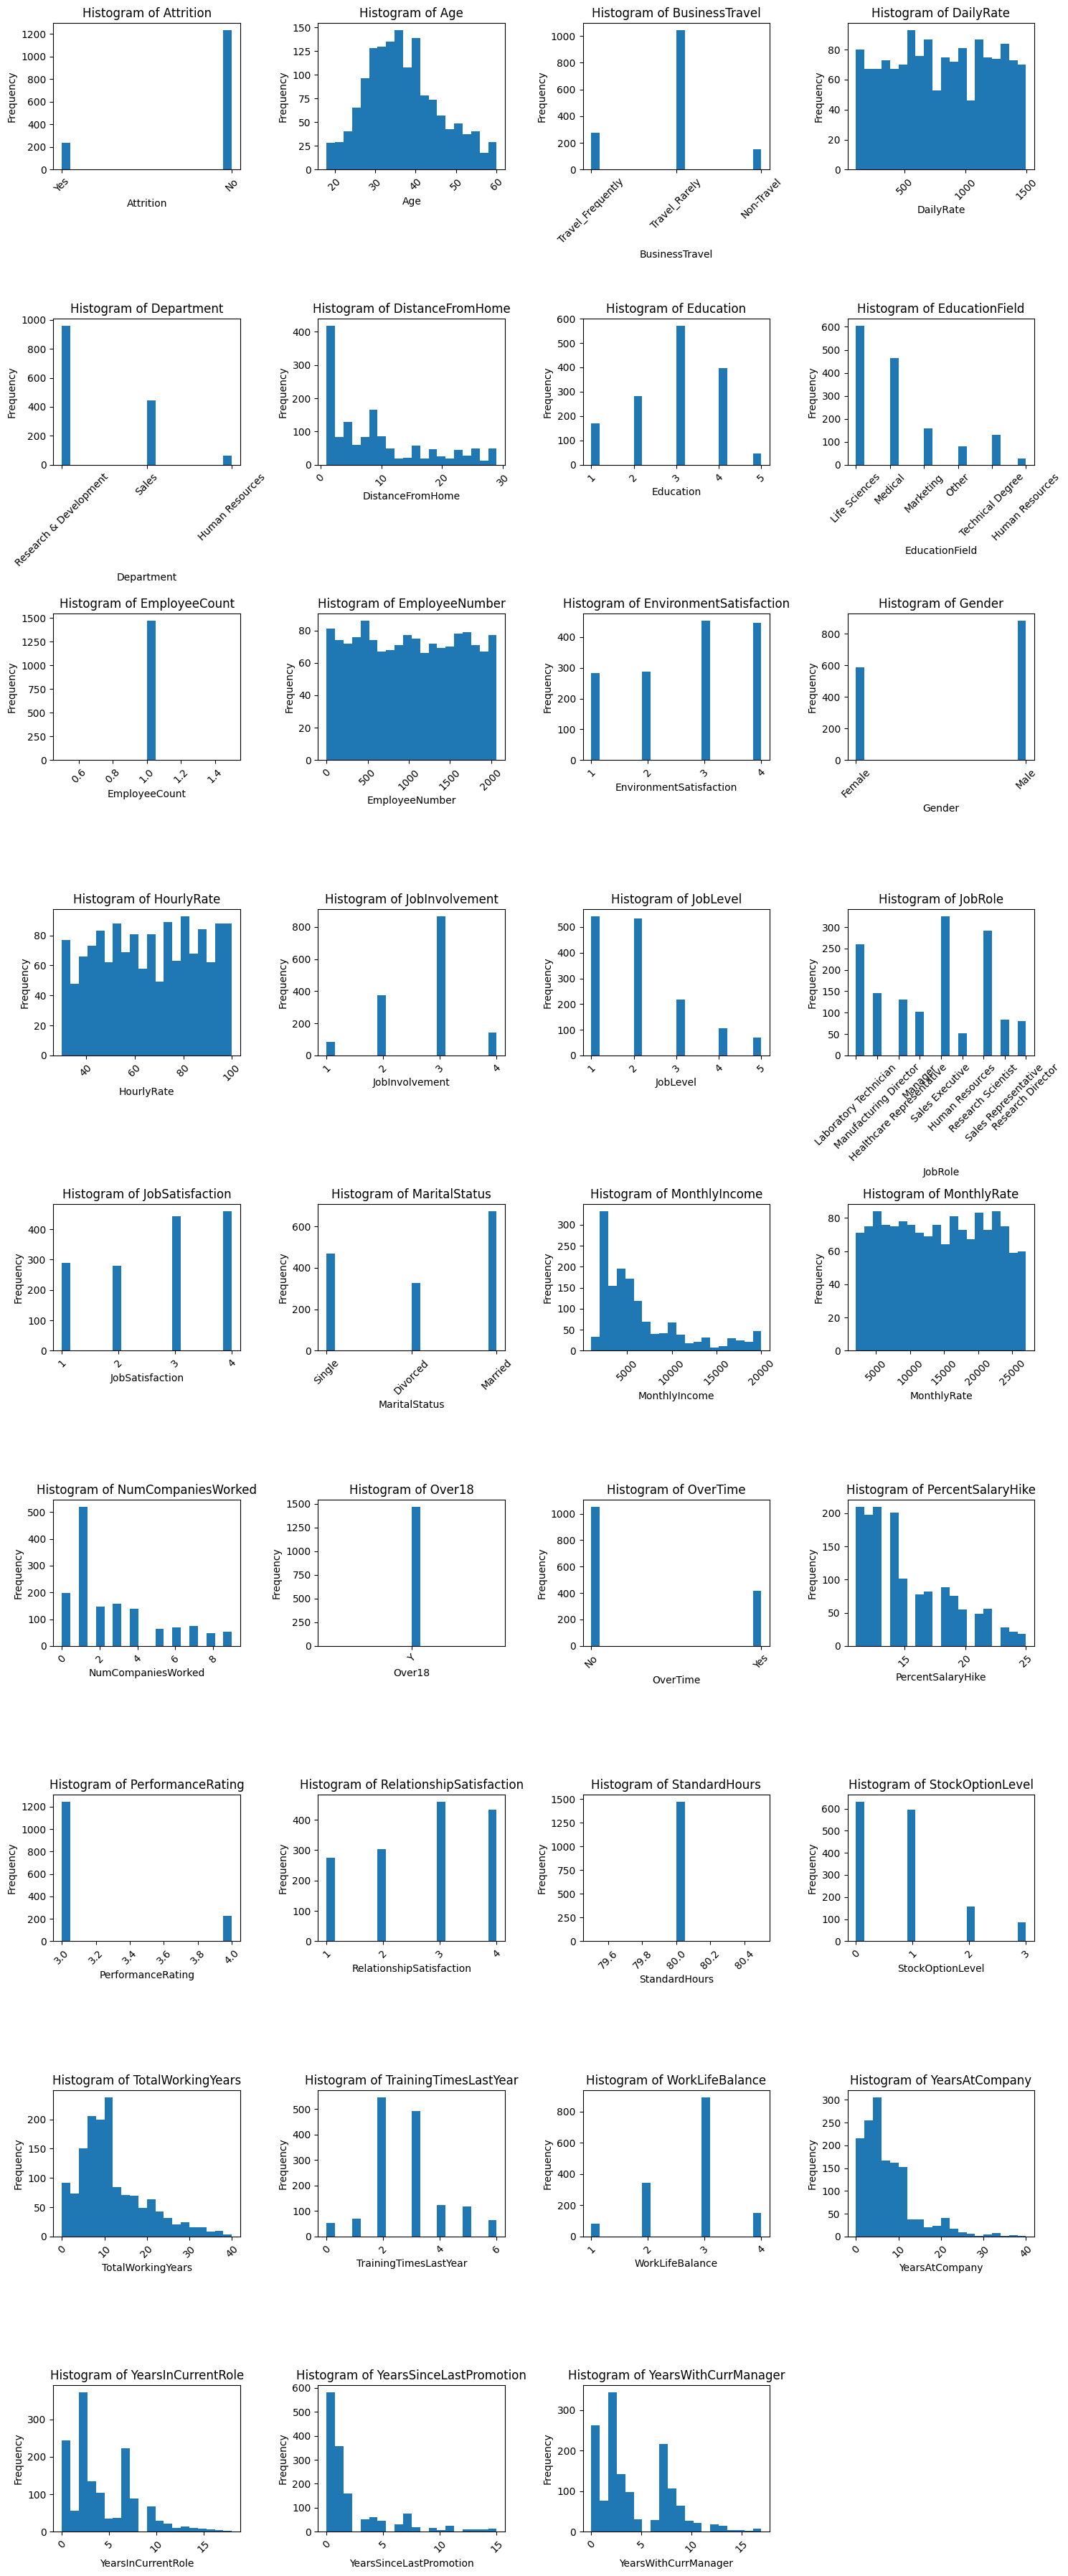

In [101]:
# Create subplots for histograms
num_cols = len(df.columns)
rows = (num_cols + 3) // 4
cols = min(4, num_cols)

fig, axes = plt.subplots(rows, cols, figsize=(15, rows * 4))  # Adjust figure size as needed

for i, col in enumerate(df.columns):
    row = i // cols
    col_index = i % cols
    ax = axes[row, col_index]

    ax.hist(df[col], bins=20)
    ax.set_title(f'Histogram of {col}')
    ax.set_xlabel(col)
    ax.set_ylabel('Frequency')
    ax.tick_params(axis='x', rotation=45)

# Remove any unused subplots
for i in range(num_cols, rows * cols):
    row = i // cols
    col_index = i % cols
    fig.delaxes(axes[row, col_index])

plt.tight_layout()
plt.show()

## Preprocessing

In [102]:
# use LabrlEncoder for label encoding classes to 0,1
labenlencoder = LabelEncoder()
df["Attrition"] = labenlencoder.fit_transform(df["Attrition"])

In [103]:
# Remove variables that do not change across the observation
df = df.drop(columns=["EmployeeCount", "EmployeeNumber", "Over18", "StandardHours"])

In [104]:
# use LabrlEncoder handle all seven categorical variables
category_columns = df.select_dtypes(include=['object'])
for column in category_columns.columns:
  df[column] = labenlencoder.fit_transform(df[column])

In [105]:
# split train test
x = df.drop(columns=['Attrition'])
y = df['Attrition']
x_train, x_test, y_train, y_test = train_test_split(x, y, stratify=y, test_size=0.20, random_state=101)

In [106]:
df.head()

,Attrition,Age,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EnvironmentSatisfaction,Gender,...,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,1,21,1,251,1,10,2,1,1,0,...,4,3,0,2,2,1,2,2,2,2
1,0,29,2,1389,1,21,4,1,2,0,...,3,3,1,10,1,3,10,9,8,8
2,0,55,0,177,1,8,1,3,4,1,...,3,4,1,34,3,3,33,9,15,0
3,0,46,2,168,2,4,2,2,4,0,...,3,3,1,26,2,3,11,4,0,8
4,0,34,2,131,2,2,3,2,3,0,...,3,4,0,4,3,3,3,2,0,2


## Plot correlation_matrix for each group vs. Attrition

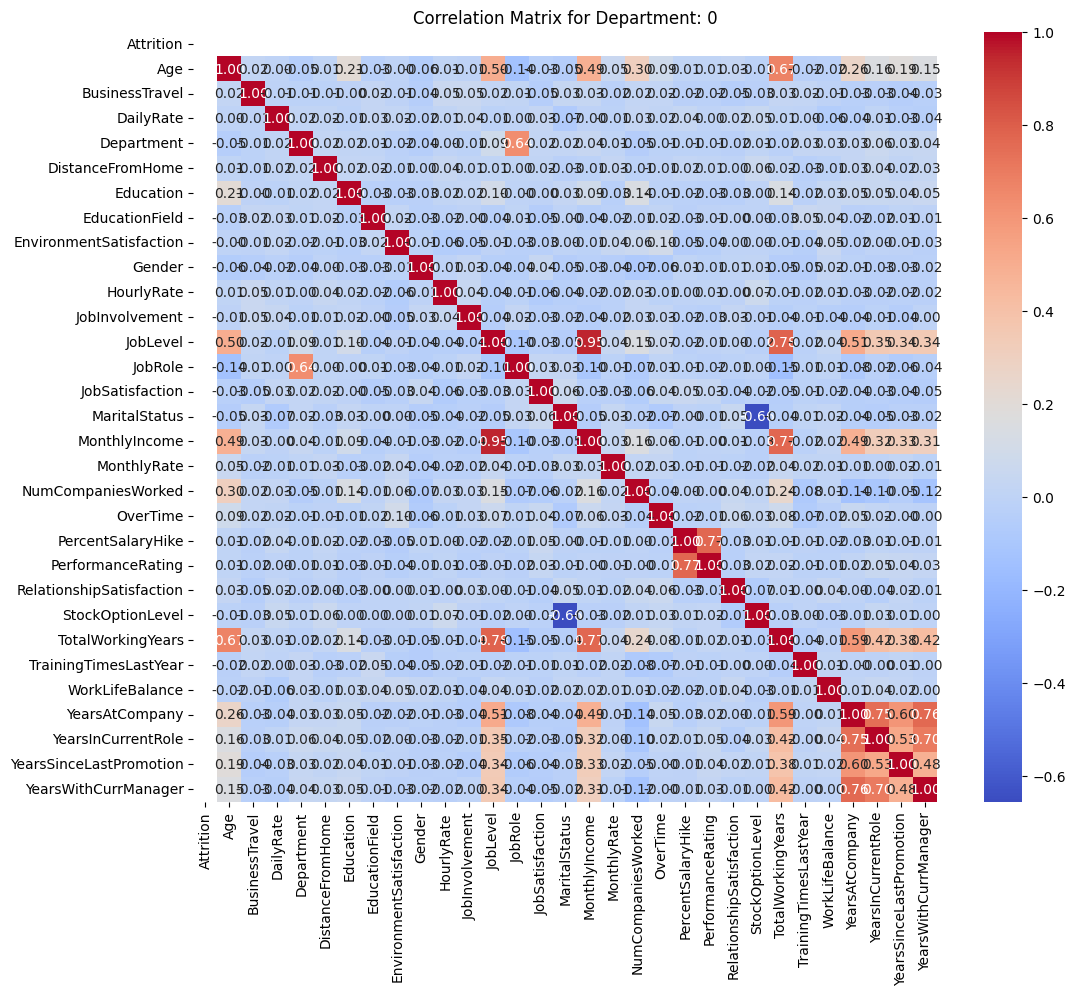

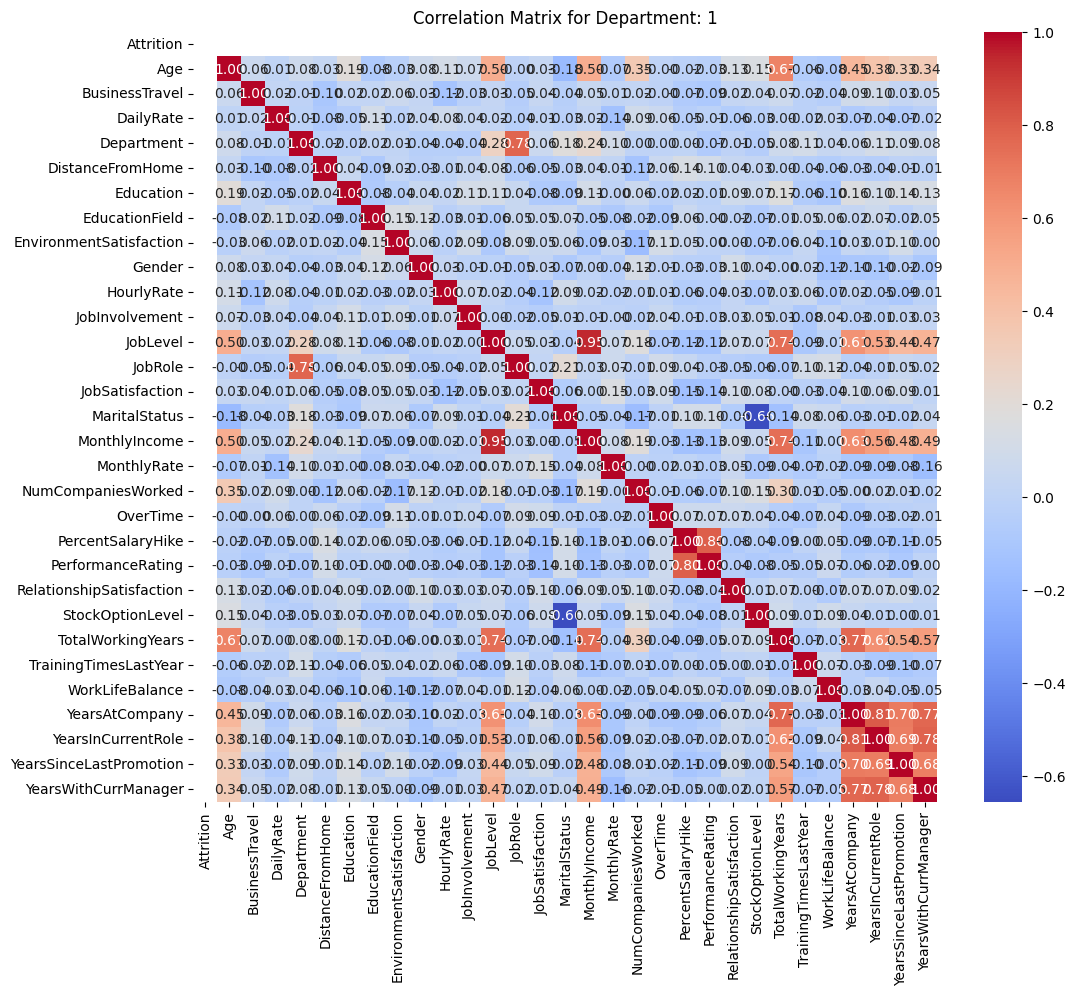

In [107]:
for group_name, group_data in df.groupby('Attrition'):
  plt.figure(figsize=(12, 10))
  correlation_matrix = group_data.corr()
  sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
  plt.title(f'Correlation Matrix for Department: {group_name}')
  plt.show()

# Decision Tree Classifier

## Call Model

In [108]:
dtree = DecisionTreeClassifier()

## Cross Validation

Model assessment with 5-fold cross validation.

In [109]:
# Cross Validation
dtree_y_pred = cross_val_predict(dtree, x_train, y_train, cv = 5)

## Report Score

In [110]:
print(classification_report(y_train, dtree_y_pred))

              precision    recall  f1-score   support

           0       0.87      0.86      0.87       986
           1       0.32      0.35      0.34       190

    accuracy                           0.78      1176
   macro avg       0.60      0.60      0.60      1176
weighted avg       0.78      0.78      0.78      1176



In [113]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

precision = precision_score(y_train, dtree_y_pred)
recall = recall_score(y_train, dtree_y_pred)
f1 = f1_score(y_train, dtree_y_pred)
accuracy = accuracy_score(y_train, dtree_y_pred)

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Accuracy:", accuracy)

Precision: 0.3235294117647059
Recall: 0.3473684210526316
F1 Score: 0.3350253807106599
Accuracy: 0.7772108843537415


## Confustion Matrix

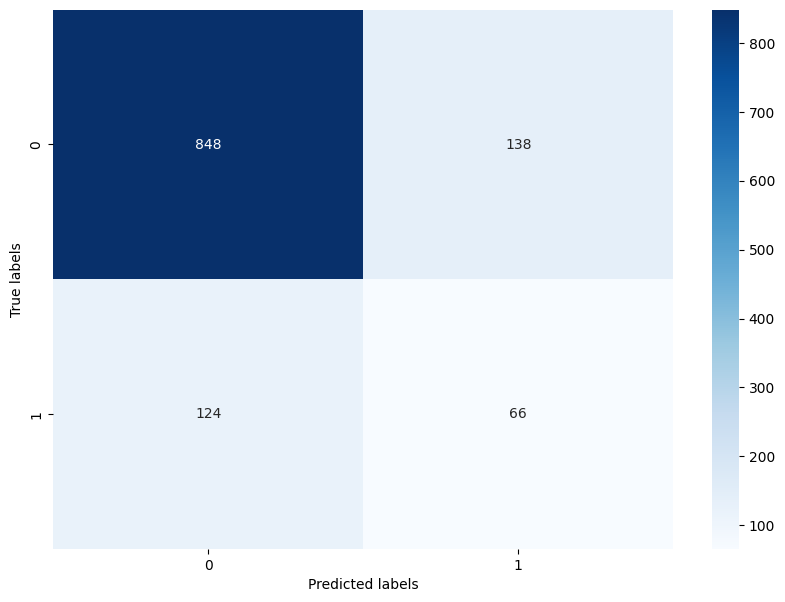

In [112]:
dtree_cm = confusion_matrix(y_train, dtree_y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(dtree_cm, annot=True, fmt = 'g', cmap = 'Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

In [111]:
print(dtree_cm)

[[852 134]
 [117  73]]


## GridSearch

In [114]:
param_grid = {
    'criterion': ['gini'],
    'min_samples_split': [7,9,11,13,15],
    'min_samples_leaf': [3,5,7,9]
}

grid_search = GridSearchCV(dtree, param_grid, cv=5, verbose=2, n_jobs=1)
grid_search.fit(x_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV] END criterion=gini, min_samples_leaf=3, min_samples_split=7; total time=   0.0s
[CV] END criterion=gini, min_samples_leaf=3, min_samples_split=7; total time=   0.0s
[CV] END criterion=gini, min_samples_leaf=3, min_samples_split=7; total time=   0.0s
[CV] END criterion=gini, min_samples_leaf=3, min_samples_split=7; total time=   0.0s
[CV] END criterion=gini, min_samples_leaf=3, min_samples_split=7; total time=   0.0s
[CV] END criterion=gini, min_samples_leaf=3, min_samples_split=9; total time=   0.0s
[CV] END criterion=gini, min_samples_leaf=3, min_samples_split=9; total time=   0.0s
[CV] END criterion=gini, min_samples_leaf=3, min_samples_split=9; total time=   0.0s
[CV] END criterion=gini, min_samples_leaf=3, min_samples_split=9; total time=   0.0s
[CV] END criterion=gini, min_samples_leaf=3, min_samples_split=9; total time=   0.0s
[CV] END criterion=gini, min_samples_leaf=3, min_samples_split=11; total time=   0.0s
[C

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_jobs=1,
             param_grid={'criterion': ['gini'],
                         'min_samples_leaf': [3, 5, 7, 9],
                         'min_samples_split': [7, 9, 11, 13, 15]},
             verbose=2)

In [115]:
best_params = grid_search.best_params_
best_cv_score = grid_search.best_score_
best_train_score = grid_search.score(x_train, y_train)
print("best parameter:", best_params)
print("best score of cross-validation:", best_cv_score)
print("best score of train:", best_train_score)

best parameter: {'criterion': 'gini', 'min_samples_leaf': 3, 'min_samples_split': 15}
best score of cross-validation: 0.8324594302199783
best score of train: 0.9175170068027211


In [116]:
# train model using best parameter
dtree = DecisionTreeClassifier(criterion=best_params['criterion'],
                               min_samples_split=best_params['min_samples_split'],
                               min_samples_leaf=best_params['min_samples_leaf'],
                               random_state = 42)
dtree.fit(x_train, y_train)

DecisionTreeClassifier(min_samples_leaf=3, min_samples_split=15,
                       random_state=42)

In [117]:
dtree_y_pred = dtree.predict(x_test)

In [118]:
print(classification_report(y_test, dtree_y_pred))

              precision    recall  f1-score   support

           0       0.86      0.91      0.88       247
           1       0.32      0.23      0.27        47

    accuracy                           0.80       294
   macro avg       0.59      0.57      0.58       294
weighted avg       0.78      0.80      0.79       294



# Decistion Tree Diagram

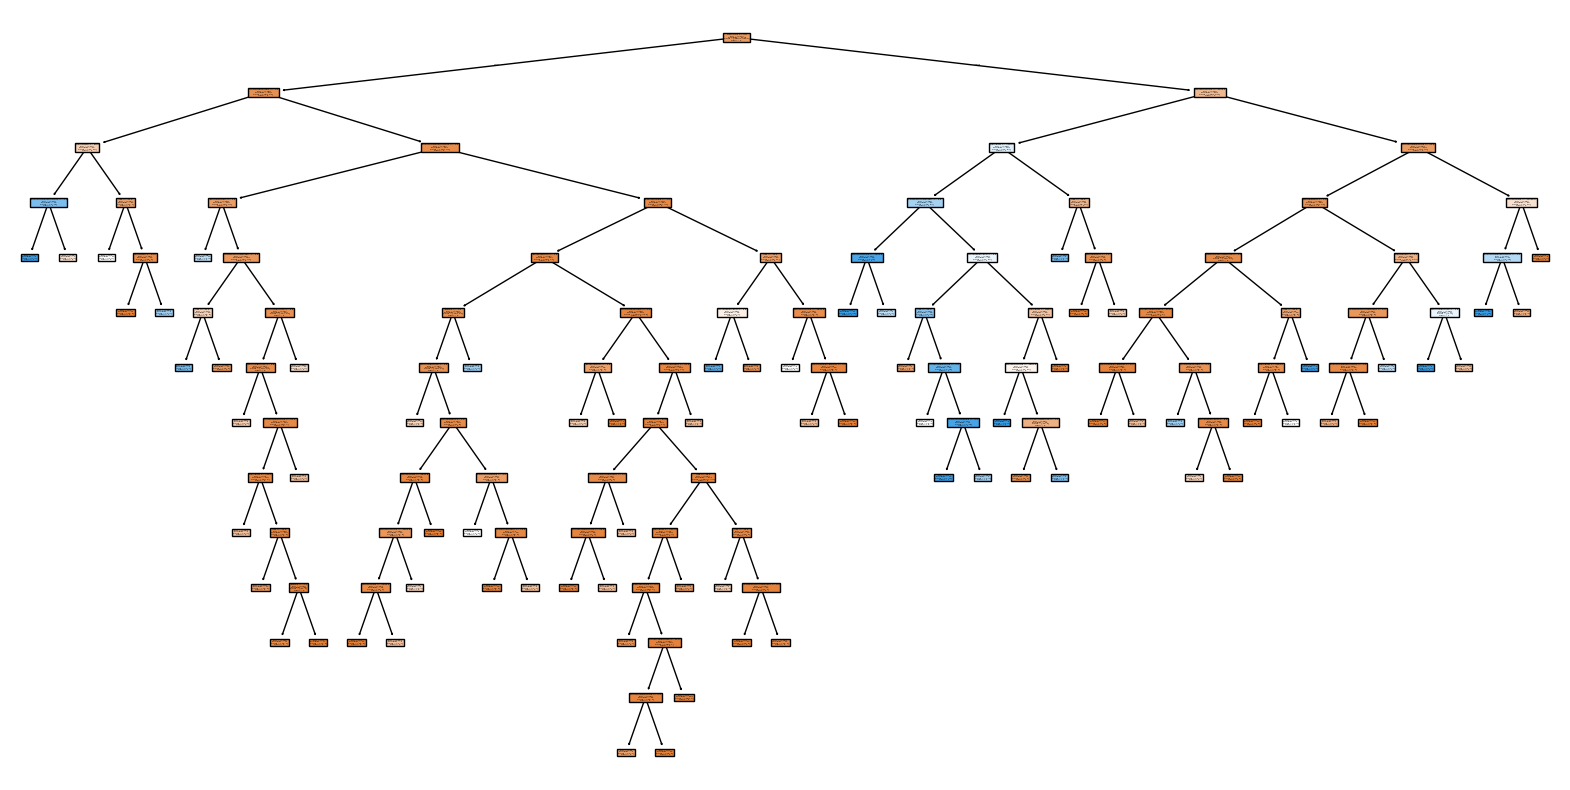

In [119]:
from sklearn.tree import plot_tree
plt.figure(figsize=(20,10))
plot_tree(dtree.fit(x_train, y_train), feature_names=x.columns, class_names=['0','1'], filled=True)
plt.show()

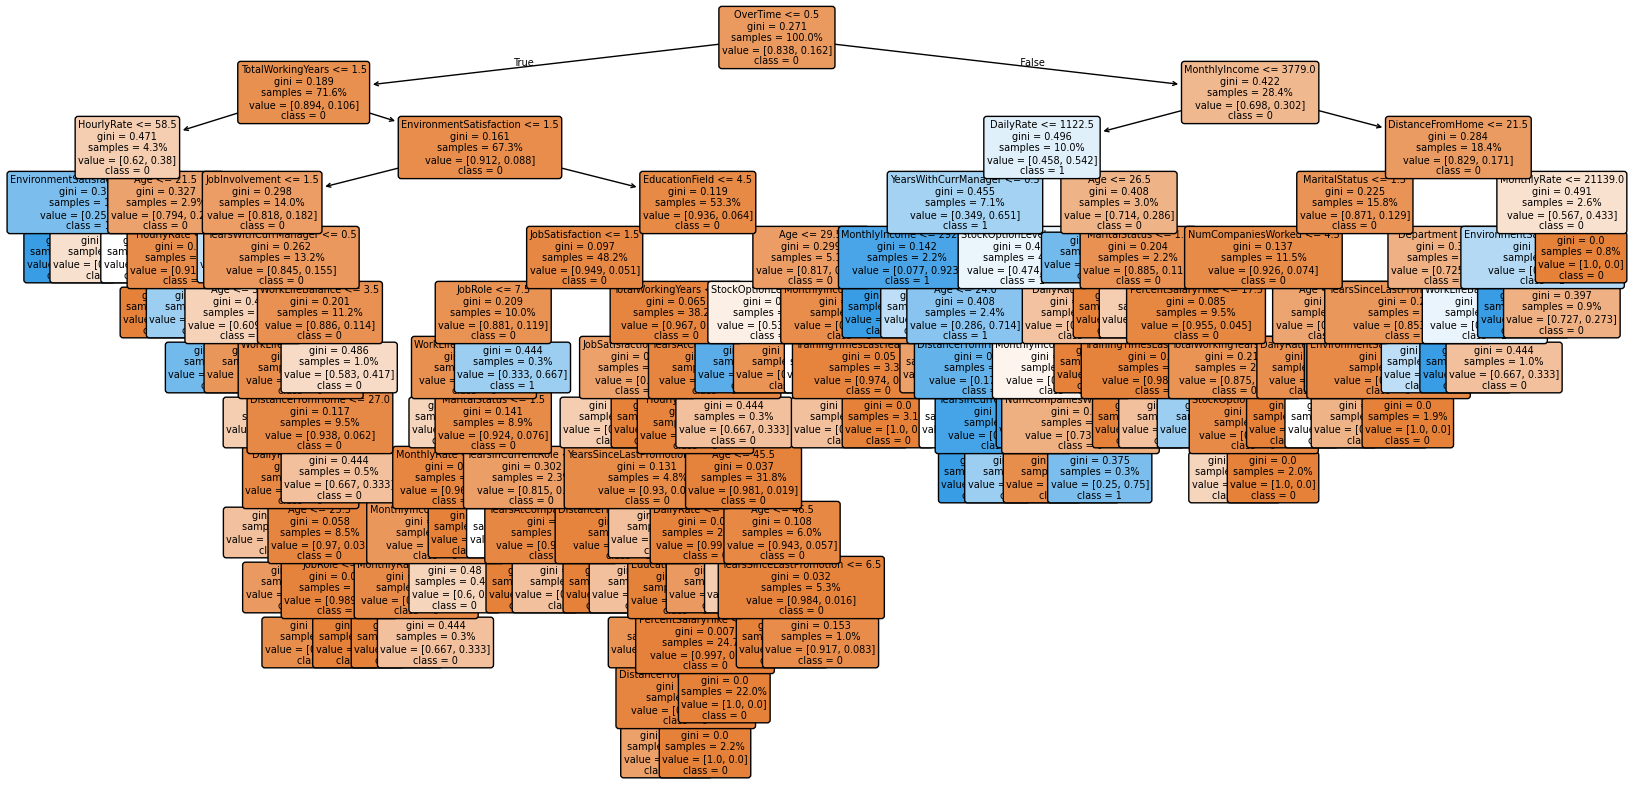

In [120]:
# Up font size
plt.figure(figsize=(20,10))
plot_tree(dtree, feature_names=x.columns, class_names=['0', '1'], filled=True, rounded=True, fontsize = 7, proportion=True)
plt.savefig('decision_tree.png')
plt.show()


# Summarization of the Colab Notebook

This notebook performs employee attrition prediction using a CART decision tree model. Here's a breakdown of the key steps:

### 1. Data Loading and Exploration

- The notebook begins by importing necessary libraries (pandas, scikit-learn, matplotlib, seaborn).
- It loads the dataset from a provided URL using `pd.read_csv`.
- It then generates histograms for each feature in the dataset, helping visualize the data distribution and identify potential outliers.

### 2. Data Preprocessing

- **Label Encoding:** It converts categorical variables (Yes/No) to numerical values (1/0) using `LabelEncoder`.
- **Removing Constant Features:** Variables with no variance (e.g., `EmployeeCount`, `EmployeeNumber`) are removed to improve model performance.
- **Handling Categorical Variables:** It further encodes the remaining categorical variables using `LabelEncoder`, converting them to numerical representations.

### 3. Train-Test Split

- The dataset is split into training and testing sets using `train_test_split`, with a 80:20 ratio for training and testing, respectively.

### 4. Correlation Analysis

- The code calculates and visualizes correlation matrices for each attrition group (positive/negative). This helps identify features that are strongly correlated with attrition.

### 5. Decision Tree Classifier

- **Model Initialization:** It instantiates a `DecisionTreeClassifier` from scikit-learn.
- **Cross-Validation:** A 5-fold cross-validation is performed on the training data using `cross_val_predict`.
- **Model Evaluation:** The model's performance is evaluated using `classification_report` and a `confusion_matrix` on the training data. These metrics provide insights into precision, recall, and F1-score.
- **Grid Search:** To find the best hyperparameters for the decision tree, a Grid Search with Cross-Validation is used to explore combinations of `min_samples_split` and `min_samples_leaf`. The best parameters are then selected.


### 6. Model Training and Testing

- Using the best hyperparameters found during Grid Search, the model is re-trained on the entire training dataset.
- The model is then used to predict attrition for the test data and the performance is reported through the classification report.

### 7. Visualization of Decision Tree

- The code generates a visual representation of the trained decision tree using `plot_tree`. This visualization allows a better understanding of how the model makes decisions.


**In essence, this notebook demonstrates a complete machine learning workflow, including data preprocessing, model training, hyperparameter tuning, model evaluation, and visualization for predicting employee attrition using a decision tree classifier.**